In [7]:
__author__ = 'Ola Olagunju'
__email__ = 'gunjujide@gmail.com'
__website__ = ''

# Data Analysis using SQL to guide Business decisions
-------------

## 1. Introduction

The aim of this project is to explore a modified version of the Chinook database using SQL and answer some business questions. The Chinook database represents a fictional digital media shop, based on real data from an iTunes Library and manually generated data. The database is provided as a SQLite database file called 'chinook.db'.  It contains information about employees, customers, purchases, and everything to do with the tracks that are on the platform (artists, albums, genres, playlists, etc.). 

Here's a schema diagram for the database:
![chinook](https://s3.amazonaws.com/dq-content/189/chinook-schema.svg)

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

## 2. Data Exploration

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


In [6]:
%%sql

SELECT      *
FROM        customer c
            INNER JOIN invoice i on i.customer_id = c.customer_id
            INNER JOIN invoice_line il on il.invoice_id = i.invoice_id
LIMIT       5


 * sqlite:///chinook.db
Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id,invoice_id,customer_id_1,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total,invoice_line_id,invoice_id_1,track_id,unit_price,quantity
18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,1,1,1158,0.99,1
18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,2,1,1159,0.99,1
18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,3,1,1160,0.99,1
18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,4,1,1161,0.99,1
18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,5,1,1162,0.99,1


## 3. Data Analysis

### I. Best-Selling Genres

The Chinook record store has just signed a deal with a new record label, and select the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

Artist Name	| Genre
-|-
Regal	| Hip-Hop
Red Tone	| Punk
Meteor and the Girls	| Pop
Slim Jim Bites	| Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA. We'll write a query to find out which genres sell the most tracks in the USA and make a recommendation for the three artists whose albums we should purchase for the store.

<ipython-input-3-ab02233a9464>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=genre_names,fontdict={'fontsize':20})


,rank,genre_name,tracks_sold,pct_sold
0,1,Rock,561,53.38
1,2,Alternative & Punk,130,12.37
2,3,Metal,124,11.80
3,4,R&B/Soul,53,5.04
4,5,Blues,36,3.43
5,6,Alternative,35,3.33
6,7,Latin,22,2.09
7,8,Pop,22,2.09
8,9,Hip Hop/Rap,20,1.90
9,10,Jazz,14,1.33


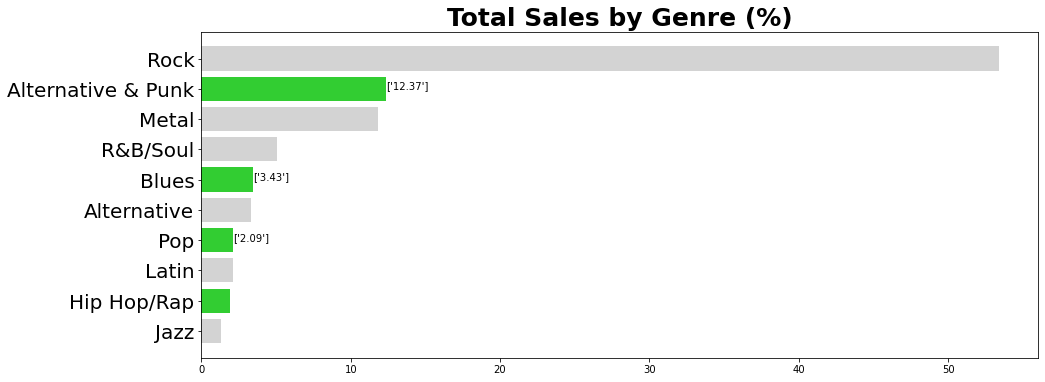

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

album_query = """
WITH 

/* Selecting the customers that are from the USA */

usa AS (SELECT * 
        FROM customer
        WHERE country = 'USA'),

/* Joining the invoice and invoice line tables to the USA customers table */

usa_il AS (SELECT * 
           FROM usa
           LEFT JOIN invoice i ON usa.customer_id = i.customer_id
           LEFT JOIN invoice_line il ON i.invoice_id = il.invoice_id),
           
/* Joining the track and genre tables to the USA customers' invoice table */ 

usa_info AS (SELECT usa_il.*,
                    g.genre_id genre_id,
                    g.name genre_name
             FROM usa_il
             LEFT JOIN track t ON usa_il.track_id = t.track_id
             LEFT JOIN genre g ON t.genre_id = g.genre_id)  
             
/* Adding the rank for the genres, and counting the tracks sold by genre */ 

SELECT ROW_NUMBER() OVER(ORDER BY COUNT(*) DESC) rank, 
       genre_name,
       COUNT(*) tracks_sold,
       ROUND(CAST(COUNT(*) AS FLOAT) / (SUM(COUNT(genre_name)) OVER())*100,2) AS pct_sold
FROM usa_info
GROUP BY genre_name
ORDER BY tracks_sold DESC

"""

conn = sqlite3.connect("chinook.db")
album = pd.read_sql_query(album_query, conn)

## Top 10 genres
top_genres = album.head(10).sort_values(by=['pct_sold'], ascending=True)

## Getting a list of all the different genres
genre_names = list(top_genres['genre_name'].values)

## Genres of the albums we are looking to add
album_genres = ['Hip Hop/Rap', 'Pop', 'Blues', 'Alternative & Punk']

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.barh(top_genres['genre_name'],top_genres['pct_sold'], color='lightgrey')

## Coloring the album's genres green
for x in album_genres:
    ax.barh(x, top_genres[top_genres['genre_name'] == x]['pct_sold'].values, color='limegreen')
    if x != 'Hip Hop/Rap':
        ax.text(x=top_genres[top_genres['genre_name']==x]['pct_sold'].values, y=x, 
                s=top_genres[top_genres['genre_name']==x]['pct_sold'].values.astype(str)) ## adding astype(str) bypasses a future warning, not sure why

ax.set_yticklabels(labels=genre_names,fontdict={'fontsize':20})
plt.title("Total Sales by Genre (%)", fontdict={'fontsize':25,'fontweight':'bold'})

album

Based on the results above, we would recommend purchasing the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.


### II. Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We'll analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

,employee_name,birthdate,hire_date,country,num_transactions,dollar_sales,pct_sales,avg_dollar_sale
0,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,Canada,1749,18246.69,38.41,10.43
1,Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,Canada,1600,15923.16,33.52,9.95
2,Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,Canada,1408,13333.32,28.07,9.47


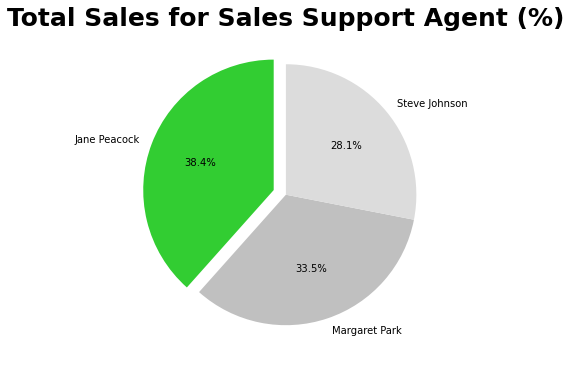

In [3]:
employee_query = """
WITH 

/* Selecting only the Sales Support Agent employees */

sales_agents AS (SELECT * 
                 FROM employee
                 WHERE title = 'Sales Support Agent'),
       
/* Joining the customer, invoice, invoice line, track, and genre tables with sales_agents */

e_info AS (SELECT * 
           FROM sales_agents s
           LEFT JOIN customer c ON s.employee_id = c.support_rep_id
           INNER JOIN invoice i ON c.customer_id = i.customer_id
           INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
           INNER JOIN track t ON il.track_id = t.track_id
           INNER JOIN (SELECT *, 
                              name genre_name
                       FROM genre) 
                       g on t.genre_id = g.genre_id)
                       
/* Selecting the employee's name and their info, their total sales in $ and in quantity */
    
SELECT first_name || ' ' || last_name employee_name,
       birthdate,
       hire_date,
       country,
       COUNT(*) num_transactions,
       ROUND(SUM(total),2) dollar_sales,
       ROUND(SUM(total) / (SELECT SUM(total)
                           FROM e_info) * 100,2) pct_sales,
       ROUND((SUM(total) / COUNT(*)),2) avg_dollar_sale
FROM e_info 
GROUP BY employee_id;

"""

employee_info = pd.read_sql_query(employee_query, conn)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()
colors = ['limegreen','silver','gainsboro']

ax.pie(x=employee_info['pct_sales'], labels=employee_info['employee_name'], colors=colors,
       explode=(0.1,0,0), autopct="%1.1f%%", startangle=90)
plt.title("Total Sales for Sales Support Agent (%)", fontdict={'fontsize':25,'fontweight':'bold'})


employee_info

There are only 3 sales support reps. From the table above, there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee). One reason may be because all three employees were hired on different dates. Jane was hired first (April 2017), then Margaret (May 2017), and Steve last (October 2017). The longer an employee has worked for Chinook, the more time he/she has had to make sales.

### III. Analyzing Sales by Country

I'll analyze the sales data for customers from each different country; calculating data for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, I'll group these customers as "Other" in the analysis.

,countries,customers,total_sales,avg_sales_per_cust,avg_order_value,avg_lifetime_purchases
0,USA,13,1040.49,10,7.94,80.04
1,Canada,8,535.59,9,7.05,66.95
2,Brazil,5,427.68,12,7.01,85.54
3,France,5,389.07,10,7.78,77.81
4,Germany,4,334.62,10,8.16,83.66
5,Czech Republic,2,273.24,15,9.11,136.62
6,United Kingdom,3,245.52,9,8.77,81.84
7,Portugal,2,185.13,14,6.38,92.57
8,India,2,183.15,10,8.72,91.58
9,Other,15,1094.94,9,7.45,73.00


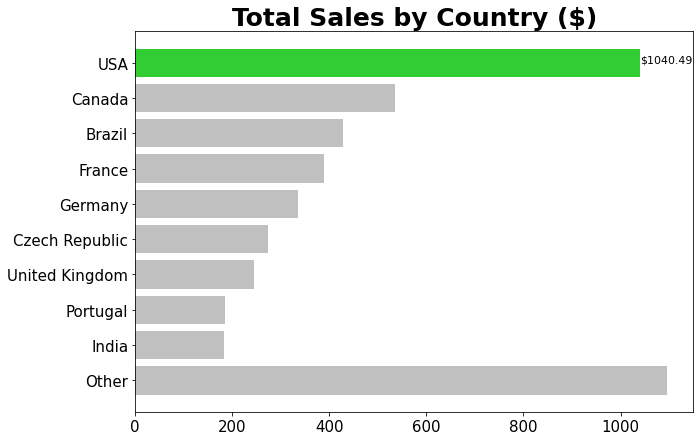

In [6]:
customer_country_query = """
WITH 

/* Counting the number of unique customers by country */

nc AS (SELECT country,
              COUNT(c.customer_id) num_cust
       FROM customer c
       GROUP BY country),
       
       
/* Joining the customer and invoice tables */

ci AS (SELECT * 
       FROM customer c
       INNER JOIN invoice i ON c.customer_id = i.customer_id),
       
       
/* Computing the sales data by country */

ci_2 AS (SELECT CASE
                    WHEN nc.num_cust = 1 THEN 'Other'
                    ELSE nc.country
                    END countries,
                COUNT(DISTINCT(customer_id)) customers,
                ROUND(SUM(ci.total),2) total_sales,
                COUNT(ci.invoice_id) / COUNT(DISTINCT(customer_id)) avg_sales_per_cust,
                ROUND(AVG(ci.total),2) avg_order_value,
                ROUND(ROUND(SUM(ci.total),2)/COUNT(DISTINCT(customer_id)), 2) avg_lifetime_purchases
         FROM nc
         INNER JOIN ci ON nc.country = ci.country
         GROUP BY countries
         ORDER BY total_sales DESC)
         
            
/* Listing the 'Other' countries last */

SELECT countries,
       customers,
       total_sales,
       avg_sales_per_cust,
       avg_order_value,
       avg_lifetime_purchases
FROM (SELECT ci_2.*,
             CASE
                 WHEN ci_2.countries = 'Other' THEN 1
                 ELSE 0
             END sort
    FROM ci_2)
ORDER BY sort ASC;

"""

customers_by_countries = pd.read_sql_query(customer_country_query, conn)

## Flipped the table to make USA appear first in the graph
cc = customers_by_countries[::-1]

fig, ax = plt.subplots(figsize=(10,7))

ax.barh(cc['countries'], cc['total_sales'], 
        color=['silver','silver','silver','silver','silver',
              'silver','silver','silver','silver','limegreen'])
ax.set_title("Total Sales by Country ($)", fontdict={'fontsize':25, 'fontweight':'bold'})
ax.tick_params(labelsize=15)
ax.text(x=cc[cc['countries']=='USA']['total_sales'],y='USA',s='$1040.49',
       fontdict={'fontsize':11})

customers_by_countries

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. However, it may be reasonable for Chinook to ramp marketing efforts in countries with large populations such as India, United States, Brazil, and Germany as marketing efforts have the potential to reach more people. Also, an alternative strategy could be to target countries whose average lifetime customer value is high. For this, countries like India, Portugal, and Czech Republic may work. If only one country can be chosen, India is a good bet as it has both a large population (+1.3 billion) and a high average lifetime customer value ($91.58).

###  IV. Albums vs. Individual Tracks

In the Chinook store, customers can make purchases in one of the two ways:

purchase a whole album,
purchase a collection of one or more individual tracks.
The store doesn't let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy so that to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album. Our task is to find out what percentage of purchases are individual tracks vs. whole albums. This data will further be used to understand the effect this new strategy might have on overall revenue.

Here we have two edge cases to consider:

Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.
In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case doesn't happen often, so we can ignore this case also.

In order to answer our question, we're going to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks, as long as we decided to ignore the second edge case.

In this way, we'll categorize each invoice as a purchase of either a whole album or individual tracks, and calculate the summary statistics for both groups (number and % of invoices). For this purpose, we'll use the following tables: invoice_line, track, and album

,purchase_type,invoice_count,pct
0,Album,111,18.08
1,Individual Tracks,503,81.92


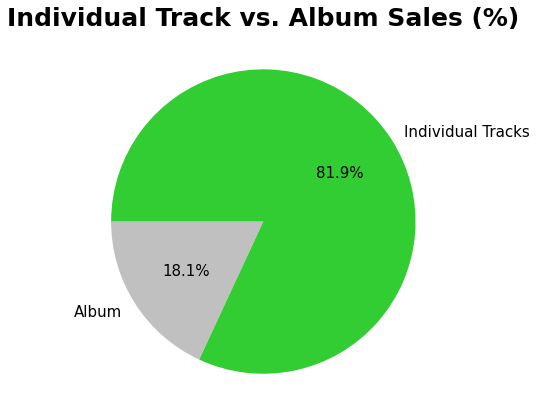

In [14]:
purchase_type_query = """
WITH 

/* Getting the amount of tracks in each album */

a_ct AS (SELECT t.album_id, 
                COUNT(t.track_id) tracks_per_album 
         FROM track t
         GROUP BY album_id),
         

/* Getting the amount of tracks based on each invoice and album */ 

t_ct AS (SELECT il.invoice_id,
                t.album_id,
                COUNT(il.track_id) track_count
         FROM track t
         INNER JOIN invoice_line il ON t.track_id = il.track_id
         GROUP BY il.invoice_id, t.album_id),
         

/* Comparing the invoice track count per album to the total track count per album */

ind_vs_alb AS (SELECT *,
                      CASE
                          WHEN t_ct.track_count != a_ct.tracks_per_album THEN 'Individual Tracks'
                          WHEN t_ct.track_count = 1 THEN 'Individual Tracks'
                          ELSE 'Album'
                      END purchase_type
               FROM t_ct
               INNER JOIN a_ct ON t_ct.album_id = a_ct.album_id)
               

/* Counting the occurrences for each purchase type */

SELECT purchase_type,
       COUNT(DISTINCT(invoice_id)) invoice_count,
       ROUND(CAST(COUNT(DISTINCT(invoice_id)) AS FLOAT) / (SELECT COUNT(DISTINCT(invoice_id)) 
                                                           FROM ind_vs_alb),4) * 100 pct
FROM ind_vs_alb
GROUP BY purchase_type;

"""

purchase_type = pd.read_sql_query(purchase_type_query, conn)

fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.pie(x=purchase_type['pct'], labels=purchase_type['purchase_type'], colors=['silver','limegreen'], 
       autopct='%1.1f%%', startangle=180, textprops={'fontsize':15})
plt.title("Individual Track vs. Album Sales (%)", fontdict={'fontsize':25,'fontweight':'bold'})

purchase_type

Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

###  V. Top artists in playlists
We'll find the artists which are the most popular in users' palylists.

In [25]:
%%sql

WITH 
    play_lists_tracks AS 
        (
            SELECT
                pl.playlist_id,
                pl.track_id,
                t.album_id,
                al.artist_id
                FROM playlist_track pl
                INNER JOIN track t ON t.track_id = pl.track_id
                INNER JOIN album al ON al.album_id = t.album_id
            ORDER BY al.artist_id                                                
        )

        
SELECT      
    ar.name AS Artist_Name,
    COUNT(plt.track_id) AS Playlist_Appearances
    FROM artist ar
    INNER JOIN play_lists_tracks plt ON plt.artist_id = ar.artist_id    
GROUP BY ar.artist_id
ORDER BY 2 DESC
LIMIT 5;

 * sqlite:///chinook.db
Done.


Artist_Name,Playlist_Appearances
Iron Maiden,516
U2,333
Metallica,296
Led Zeppelin,252
Deep Purple,226


###  VI. Is the range of tracks in the store reflective of their sales popularity?

The Chinook store may be looking to diversify their store's selection. They would want to find out if having more diverse tracks correlate with sales popularity. To do this, we will find the total number of tracks in each genre and the total sales for each. We can retrieve this information from the track, genre, invoice, and invoice_line tables.

,total_sales,total_tracks
total_sales,1.000000,0.929652
total_tracks,0.929652,1.000000


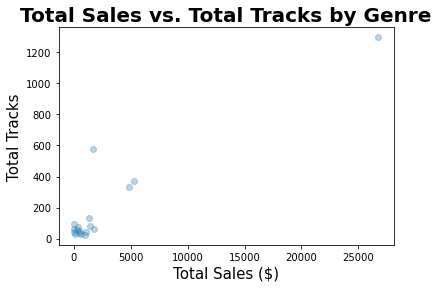

In [16]:
t_variety_vs_sales_query = """

WITH 

/* Total number of tracks for each genre */

total_tracks AS (SELECT g.name genre_name,
                        COUNT(t.track_id) total_tracks
                 FROM track t
                 INNER JOIN genre g ON t.genre_id=g.genre_id
                 GROUP BY genre_name),
                 
                 
/* Total sales for each genre */

total_sales AS (SELECT g.name genre_name,
                       ROUND(SUM(i.total),2) total_sales
                FROM track t
                INNER JOIN genre g ON t.genre_id=g.genre_id
                INNER JOIN invoice_line il ON t.track_id=il.track_id
                INNER JOIN invoice i ON il.invoice_id=i.invoice_id
                GROUP BY genre_name)

SELECT ts.*,
       tt.total_tracks
FROM total_sales ts
INNER JOIN total_tracks tt ON ts.genre_name=tt.genre_name

"""

data = pd.read_sql_query(t_variety_vs_sales_query, conn)

plt.scatter(data['total_sales'], data['total_tracks'], alpha=0.3)
plt.title("Total Sales vs. Total Tracks by Genre", fontdict={'fontsize':20,'fontweight':'bold'})
plt.xlabel("Total Sales ($)", fontsize=15)
plt.ylabel("Total Tracks", fontsize=15)

## Correlation table
data.corr()

Based on the results above, we can see that there is a strong positive correlation with total tracks and total sales for each genre, with a R-squared value of .929.

From this, we can recommend Chinook to find the most popular tracks in each genre and diversify their store selection.

# 4. Conclusion

Through the performed analysis we have found answers to business questions that will aid Chinook management decision-making.

With regards to genre popularity, the analysis shows that with 53.4% of tracks sold, Rock is the most popular genre on the platform. Rock is followed by Alternative & Punk and Metal, each with about 12% of tracks sold. This is confirmed by the ten artists with the most tracks sold: Queen, Jimmi Hendrix, Red Hot Chili Peppers, Pearl Jam, AC/DC, Guns N' Roses, Foo Fighters, The Rolling Stones, and Metallica. However, considering the four artists that Chinook can potentially bring in, the recommendation is to bring in Red Tone, Slim Jim Bites, and Meteor and the Girls. This recommendation is based on the fact that the genres of these three artists (Punk, Blues, and Pop, respectively) are the most popular of the four options.

The sales totals attributed to each Sales Support Agent are as follows: Jane Peacock with 1731.51, Margaret Park with 1,584.00, and Steve Johnson with $1,393.92. It is interesting to note that the order in which these employees were hired is the same. In other words, Jane was hired first, then Margaret, and last Steve. Considering this, the sales totals, or rather, the order of sales totals makes sense.

When considering countries for which to expand marketing efforts in, it makes sense to target countries with large populations and high average lifetime customer values. One country that meets both of these criteria is India. India has a population of over 1.3 billion and customers average lifetime totals of $91.58. Other countries, such as the US, Germany, Brazil, Portugal, and Czech Republic meet one, not both of the criteria.

Also, we have figured out that album sales make up 19% of all sales but, most importantly, 31% of total revenue. For this reason, it is not recommended to eliminate whole albums from Chinook in favor of single tracks only. Doing so can potentially lead to a loss of a fifth of revenue.